# RNN Time Series example using Tensorflow
Justin Brandenburg, MapR Technologies

In [24]:
#What are we working with?
import sys
sys.version

'3.6.9 (default, Nov  7 2019, 10:44:02) \n[GCC 8.3.0]'

In [0]:
#Import Libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

In [26]:
#TF Version
tf.__version__

'1.15.0'

#### Generate some data

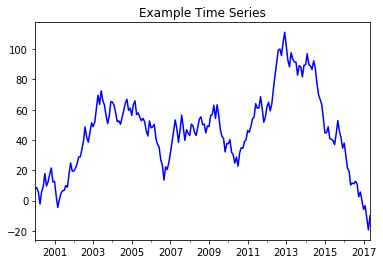

2000-01-31     7.952233
2000-02-29     8.471432
2000-03-31     5.379141
2000-04-30    -2.329382
2000-05-31     5.954047
2000-06-30     9.306212
2000-07-31    17.815975
2000-08-31     9.616297
2000-09-30    12.422173
2000-10-31    17.209890
Freq: M, dtype: float64

In [27]:
random.seed(111)
rng = pd.date_range(start='2000', periods=209, freq='M')
ts = pd.Series(np.random.uniform(-10, 10, size=len(rng)), rng).cumsum()
ts.plot(c='b', title='Example Time Series')
plt.show()
ts.head(10)

#### Convert data into array that can be broken up into training "batches" that we will feed into our RNN model.  Note the shape of the arrays. 

In [28]:
TS = np.array(ts)
num_periods = 20
f_horizon = 1  #forecast horizon, one period into the future

x_data = TS[:(len(TS)-(len(TS) % num_periods))]
x_batches = x_data.reshape(-1, 20, 1)

y_data = TS[1:(len(TS)-(len(TS) % num_periods))+f_horizon]
y_batches = y_data.reshape(-1, 20, 1)
print (len(x_batches))
print (x_batches.shape)
print (x_batches[0:2])

print (y_batches[0:1])
print (y_batches.shape)

10
(10, 20, 1)
[[[ 7.9522331 ]
  [ 8.47143209]
  [ 5.37914072]
  [-2.32938198]
  [ 5.95404749]
  [ 9.30621236]
  [17.81597481]
  [ 9.61629743]
  [12.42217317]
  [17.20989045]
  [21.46576082]
  [12.19398465]
  [12.70896127]
  [ 3.46379741]
  [-4.50855968]
  [ 0.5849665 ]
  [ 4.7191381 ]
  [ 6.40469818]
  [ 6.67443898]
  [ 9.85501855]]

 [[ 8.79862196]
  [17.31174387]
  [24.83275218]
  [19.46185787]
  [19.443666  ]
  [21.28148895]
  [24.09915328]
  [28.71658492]
  [28.83362857]
  [33.69764337]
  [39.43937025]
  [48.61782839]
  [41.72213398]
  [38.50596954]
  [44.98702236]
  [51.32706155]
  [48.80701365]
  [51.69121887]
  [60.88782199]
  [69.55011174]]]
[[[ 8.47143209]
  [ 5.37914072]
  [-2.32938198]
  [ 5.95404749]
  [ 9.30621236]
  [17.81597481]
  [ 9.61629743]
  [12.42217317]
  [17.20989045]
  [21.46576082]
  [12.19398465]
  [12.70896127]
  [ 3.46379741]
  [-4.50855968]
  [ 0.5849665 ]
  [ 4.7191381 ]
  [ 6.40469818]
  [ 6.67443898]
  [ 9.85501855]
  [ 8.79862196]]]
(10, 20, 1)


#### Pull out our test data

In [29]:
def test_data(series,forecast,num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, 20, 1)
    testY = TS[-(num_periods):].reshape(-1, 20, 1)
    return testX,testY

X_test, Y_test = test_data(TS,f_horizon,num_periods )
print (X_test.shape)
print (X_test)

(1, 20, 1)
[[[ 52.80863905]
  [ 45.64943727]
  [ 41.53552773]
  [ 34.59249302]
  [ 37.91060432]
  [ 29.50729578]
  [ 21.29616231]
  [ 19.40776705]
  [ 10.30011998]
  [ 11.54376528]
  [ 11.03725791]
  [ 12.74808779]
  [ 10.79183712]
  [  2.45946589]
  [  5.6375354 ]
  [ -0.26056979]
  [ -5.87675755]
  [ -3.46083166]
  [-11.33745541]
  [-19.40893886]]]


In [0]:
tf.reset_default_graph()   #We didn't have any previous graph objects running, but this would reset the graphs

num_periods = 20      #number of periods per vector we are using to predict one period ahead
inputs = 1            #number of vectors submitted
hidden = 100          #number of neurons we will recursively work through, can be changed to improve accuracy
output = 1            #number of output vectors

X = tf.placeholder(tf.float32, [None, num_periods, inputs])   #create variable objects
y = tf.placeholder(tf.float32, [None, num_periods, output])


basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)   #create our RNN object
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)               #choose dynamic over static

learning_rate = 0.001   #small learning rate so we don't overshoot the minimum

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])           #change the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)        #specify the type of layer (dense)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])          #shape of results
 
loss = tf.reduce_sum(tf.square(outputs - y))    #define the cost function which evaluates the quality of our model
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)          #gradient descent method
training_op = optimizer.minimize(loss)          #train the result of the application of the cost_function                                 

init = tf.global_variables_initializer()           #initialize all the variables

In [31]:
epochs = 1000     #number of iterations or training cycles, includes both the FeedFoward and Backpropogation

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, "\tMSE:", mse)
    
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)

0 	MSE: 768802.7
100 	MSE: 19521.254
200 	MSE: 9001.442
300 	MSE: 4012.698
400 	MSE: 2813.0005
500 	MSE: 2201.0984
600 	MSE: 1693.7249
700 	MSE: 1412.6764
800 	MSE: 1254.2141
900 	MSE: 1161.4174
[[[54.804573 ]
  [43.8256   ]
  [40.31037  ]
  [42.320972 ]
  [42.996403 ]
  [25.800209 ]
  [25.7535   ]
  [13.405366 ]
  [-7.7017336]
  [27.021193 ]
  [ 9.291475 ]
  [ 6.208056 ]
  [10.982834 ]
  [ 5.113061 ]
  [-4.5069523]
  [ 7.7335577]
  [ 1.0954959]
  [11.631861 ]
  [-1.3878434]
  [-0.5596173]]]


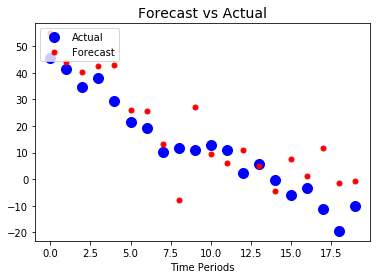

In [32]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), "bo", markersize=10, label="Actual")
#plt.plot(pd.Series(np.ravel(Y_test)), "w*", markersize=10)
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

plt.show()



In [34]:
preds = []
last_n_steps_value = [40]
n_steps = 20
number_you_want_to_predict = 25
X_batch = last_n_steps_value
X_batch = X_batch.reshape(-1, n_steps, 1)
for i in range(number_you_want_to_predict):
  pred = sess.run(outputs, feed_dict={X: X_batch})
  preds.append(pred.reshape(7)[-1])
  X_batch = X_batch[:, 1:]
  # Using predict value to replace real value
  X_batch = np.append(X_batch, pred[:, -1])
  X_batch = X_batch.reshape(-1, n_steps, 1)

AttributeError: ignored